In [1]:
import cv2
import numpy as np

%pylab inline

Populating the interactive namespace from numpy and matplotlib


True

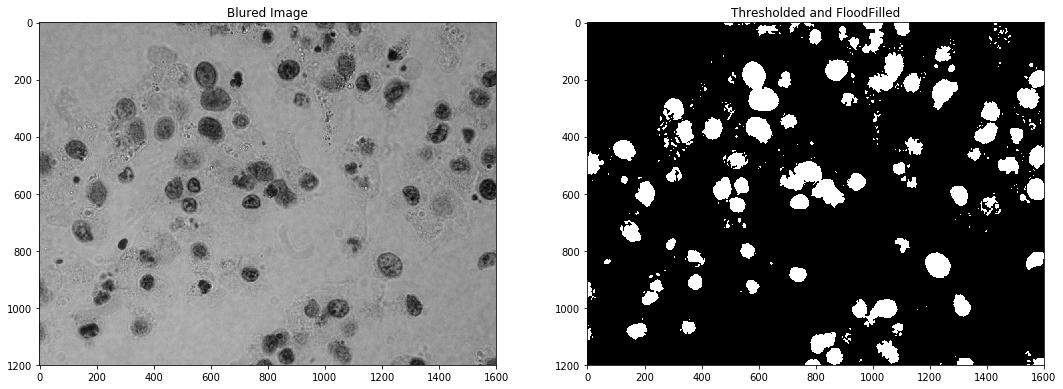

In [30]:
# Read image
img = cv2.imread("1.bmp");
gray = cv2.cvtColor(img,cv2.COLOR_BGR2GRAY)

# noise reduction and thresholding
blured = cv2.medianBlur(gray,5)
ret, thresh = cv2.threshold(-blured,0,255,cv2.THRESH_BINARY+cv2.THRESH_OTSU)
 
# Copy the thresholded image.
im_floodfill = thresh.copy()
 
# Mask used to flood filling.
# Notice the size needs to be 2 pixels than the image.
h, w = gray.shape[:2]
mask = np.zeros((h+2, w+2), np.uint8)
 
# Floodfill from point (0, 0)
cv2.floodFill(im_floodfill, mask, (0,0), 255);
 
# Invert floodfilled image
im_floodfill_inv = cv2.bitwise_not(im_floodfill)
 
# Combine the two images to get the foreground.
thresh = thresh | im_floodfill_inv
 
pylab.rcParams['figure.figsize'] = (18, 10)
    
# Display images.
plt.subplot(1,2,1),plt.imshow(gray, 'gray')
plt.title("Blured Image")
plt.subplot(1,2,2),plt.imshow(thresh, 'gray')
plt.title("Thresholded and FloodFilled")

cv2.imwrite('2a.png', img)
cv2.imwrite('2b.png', thresh)

True

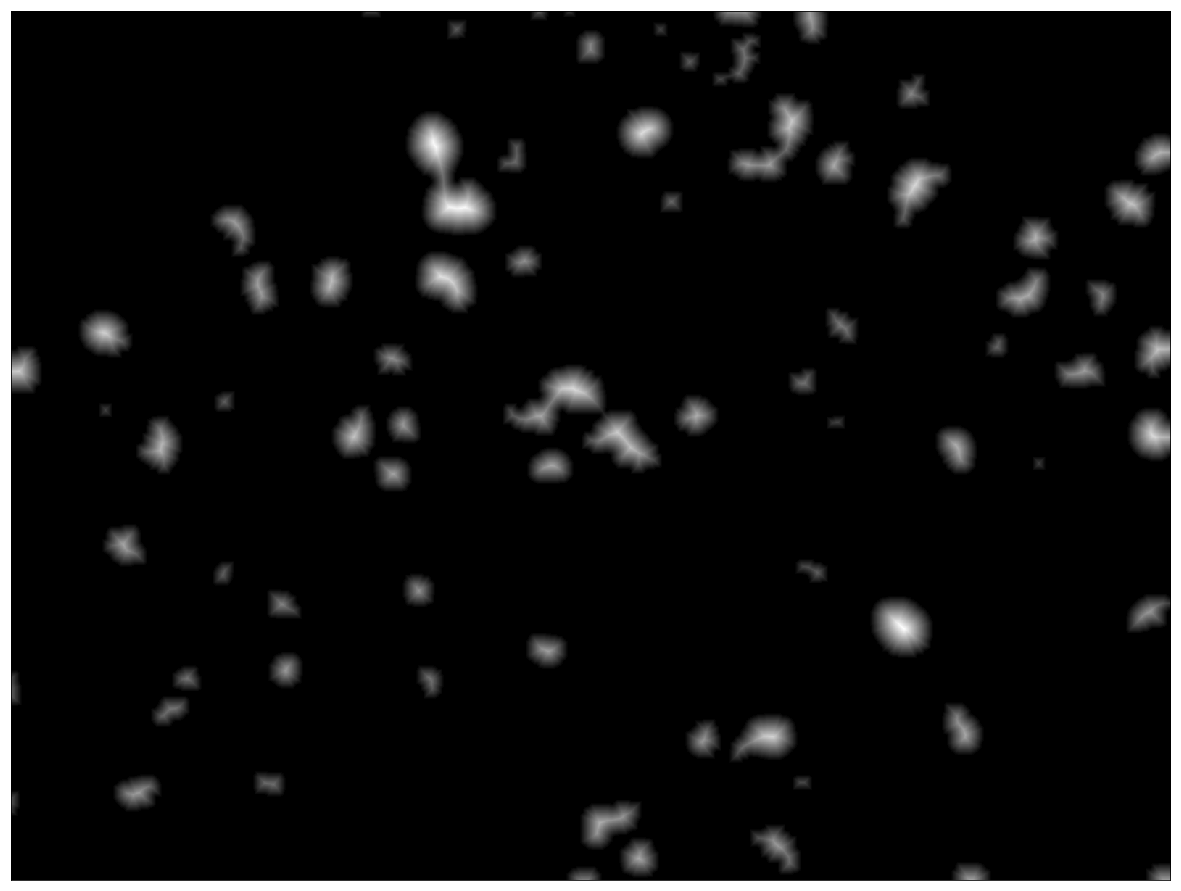

In [37]:
# noise removal
kernel = np.ones((9,9),np.uint8)
opening = cv2.morphologyEx(thresh,cv2.MORPH_OPEN,kernel, iterations = 2)

# sure background area
sure_bg = cv2.dilate(opening,kernel,iterations=2)
#sure_fg = cv2.erode(thresh,None,iterations = 2)

border = cv2.Canny(thresh, 0, 255)
#border = sure_bg - cv2.erode(sure_bg, None)
cv2.imwrite('border.png', border)

# Finding sure foreground area
dist_transform = cv2.distanceTransform(opening,cv2.DIST_L2, 5)
#dist_transform = cv2.normalize(dist_transform, 0, 1, cv2.NORM_MINMAX)
ret, sure_fg = cv2.threshold(dist_transform,0.475*dist_transform.max(),255,cv2.THRESH_BINARY)

ret, lower_fg = cv2.threshold(dist_transform,0.3*dist_transform.max(),255,cv2.THRESH_BINARY)
ret, upper_fg = cv2.threshold(dist_transform,0.45*dist_transform.max(),255,cv2.THRESH_BINARY)
range_fg = cv2.bitwise_xor(lower_fg, upper_fg)

# Finding unknown region
sure_fg = np.uint8(sure_fg)
unknown = cv2.subtract(sure_bg,sure_fg)

#combined = dist_transform.copy()
#combined[border == 255] = dist_transform.max()
combined = sure_fg.copy()
combined[border == 255] = 255

# Now just draw the graphics
pylab.rcParams['figure.figsize'] = (24, 16)

#plt.subplot(1,2,1)
plt.imshow(dist_transform, 'gray')
#plt.title('distance transform')
plt.xticks([]),plt.yticks([])

#plt.subplot(1,2,2),plt.imshow(sure_fg,'gray')
#plt.title('sure foreground')
#plt.xticks([]),plt.yticks([])

cv2.imwrite('figures/4a.png', dist_transform)
cv2.imwrite('figures/4b.png', sure_fg)

0 54


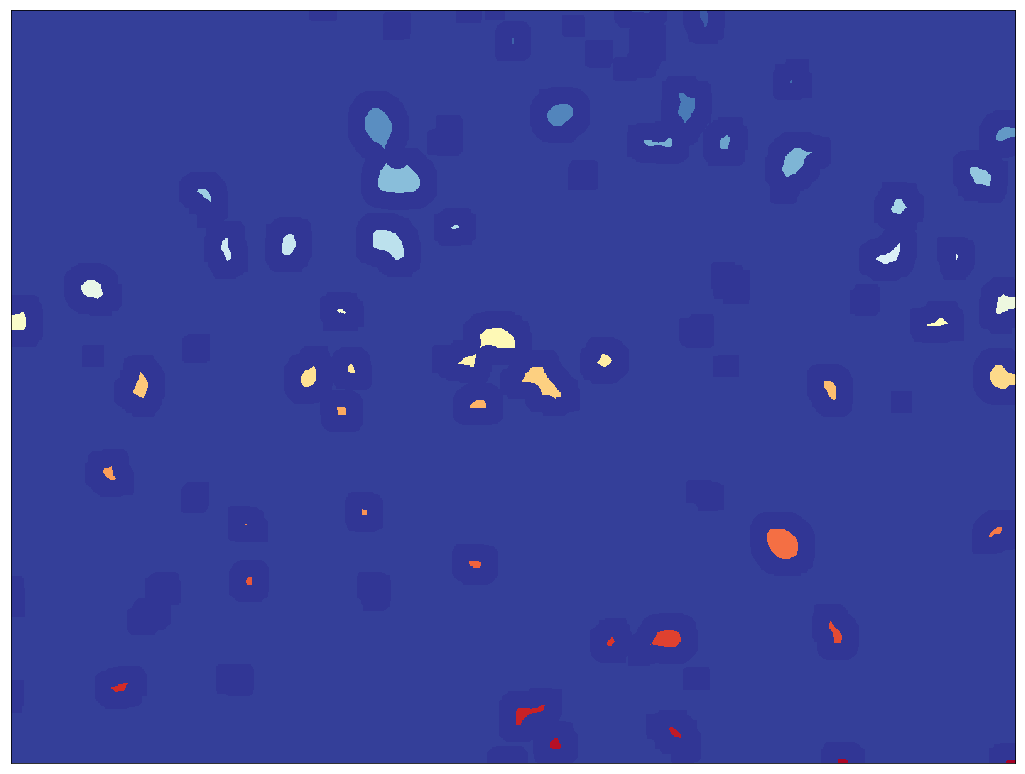

In [74]:
# Marker labelling
ret, markers = cv2.connectedComponents(sure_fg)
 
# Add one to all labels so that sure background is not 0, but 1
markers = markers+1
 
# Now, mark the region of unknown with zero
markers[unknown==255] = 0
#markers[border==255] = 255

# Show the markers
pylab.rcParams['figure.figsize'] = (18, 18)

#plt.subplot(1,2,1),plt.imshow(img,'gray')
#plt.title('original')
#plt.xticks([]),plt.yticks([])

#plt.subplot(1,2,2),


plt.imshow(markers, cmap='RdYlBu_r')
cv2.imwrite('figures/aa.png', markers)
#plt.title('marker')
plt.xticks([]),plt.yticks([])

print(np.min(markers), np.max(markers))

54
-1


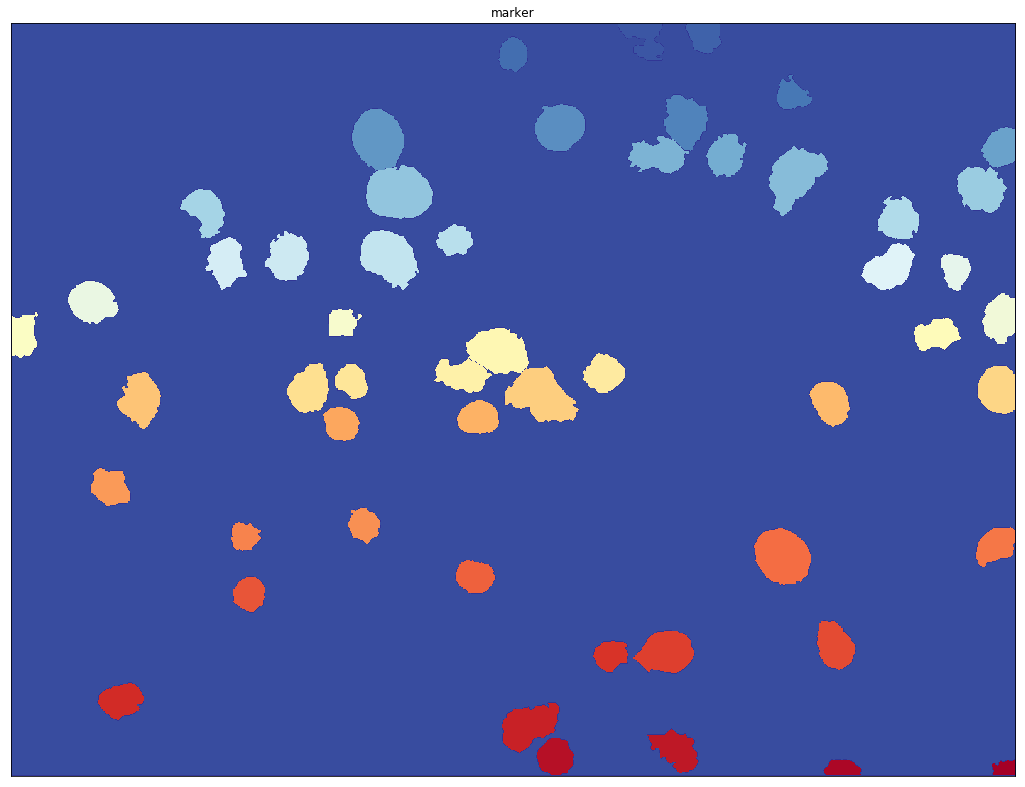

In [69]:
img2 = cv2.bitwise_not(img, 0, 255-thresh)
markers = cv2.watershed(img2,markers)

result = cv2.medianBlur(img, 5)
result[markers == -1] = [0,255,0]

# Show the markers
pylab.rcParams['figure.figsize'] = (18, 18)

#plt.subplot(2,1,1),plt.imshow(result)
#plt.title('original')
#plt.xticks([]),plt.yticks([])

#plt.subplot(2,1,2),
plt.imshow(markers, cmap='RdYlBu_r')
plt.title('marker')
plt.xticks([]),plt.yticks([])

print(markers.max())
print(markers.min())

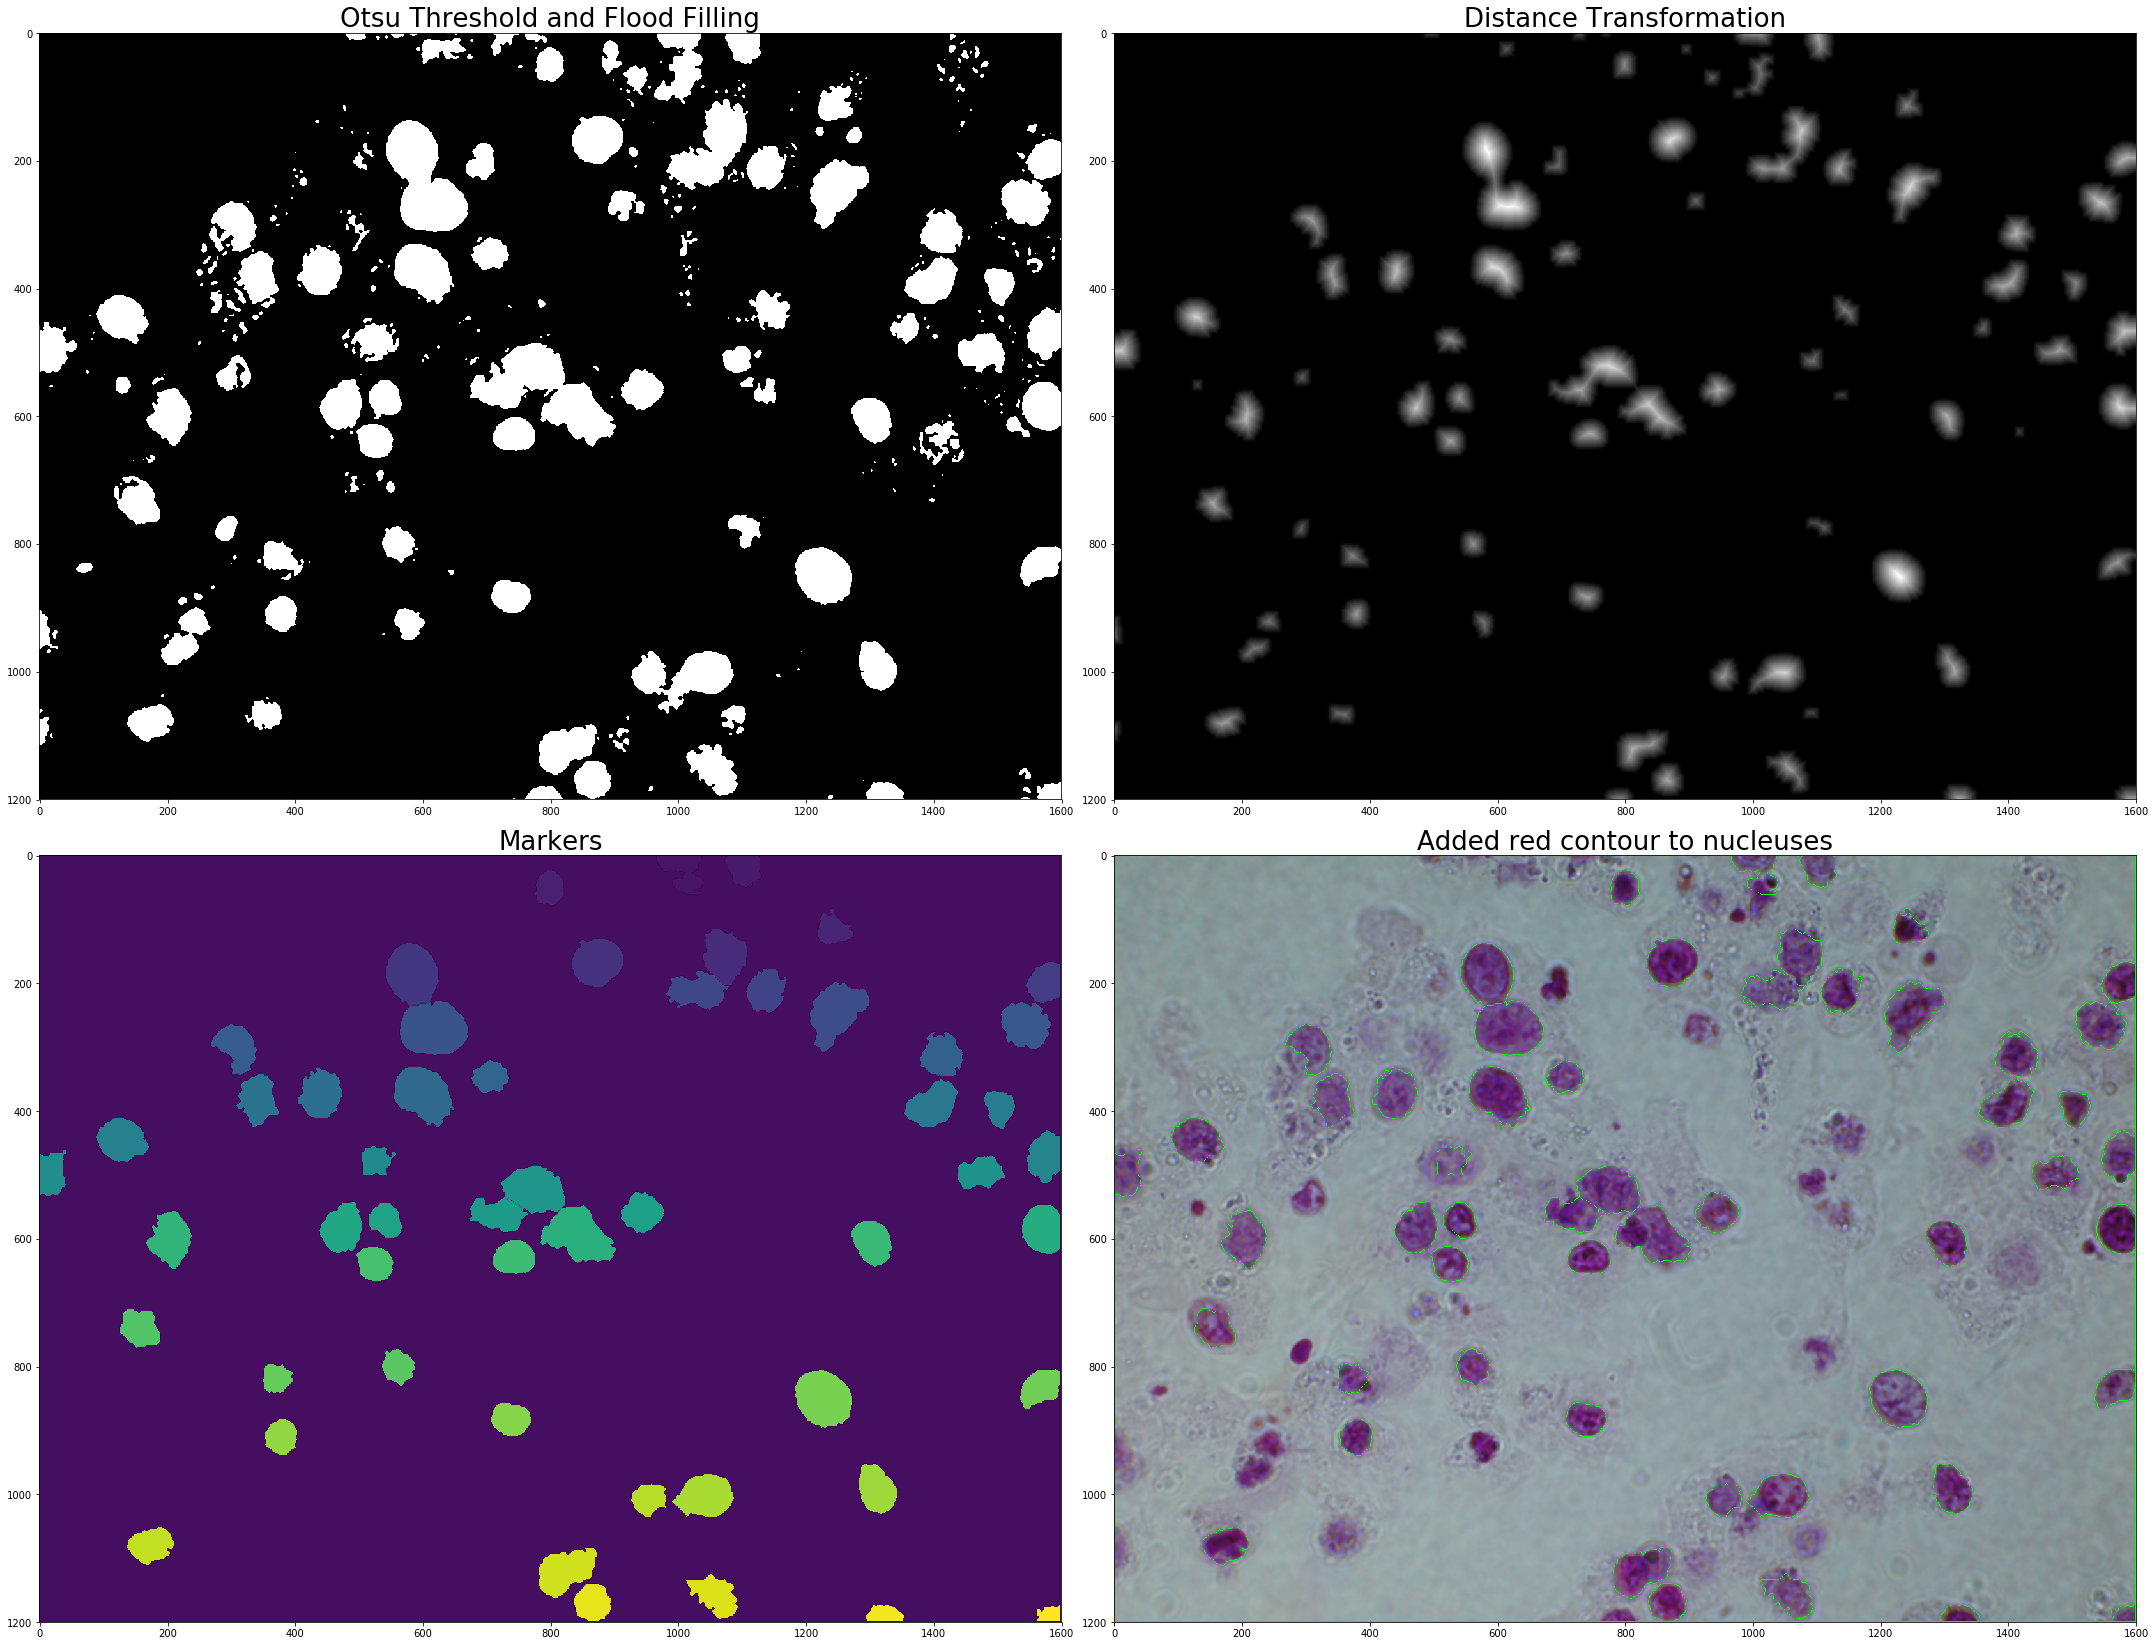

In [34]:
# Display images.
# Show the markers

pylab.rcParams['figure.figsize'] = (30, 23)

fig = plt.figure()

subplot1 = fig.add_subplot(221)
subplot1.imshow(thresh, 'gray')
subplot1.set_title("Otsu Threshold and Flood Filling", size=26)

subplot2 = fig.add_subplot(222)
subplot2.imshow(dist_transform, 'gray')
subplot2.set_title("Distance Transformation", size=26)

subplot3 = fig.add_subplot(223)
subplot3.imshow(markers)
subplot3.set_title("Markers", size=26)

subplot4 = fig.add_subplot(224)
subplot4.imshow(result)
subplot4.set_title("Added red contour to nucleuses", size=26)

fig.tight_layout()

fig.savefig('result.png')
plt.show()

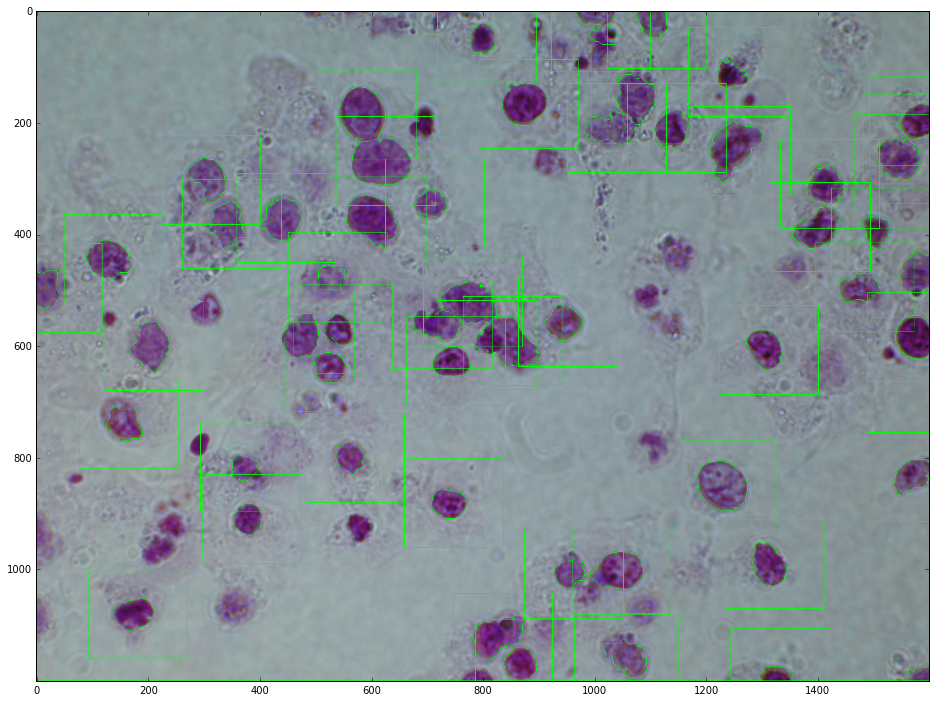

In [20]:
left = dict([])
right = dict([])
top = dict([])
bottom = dict([])

for row in range(markers.shape[0]):
    for col in range(markers.shape[1]):
        if not markers[row][col] in left:
            left[markers[row][col]] = col
        if col < left[markers[row][col]]:
            left[markers[row][col]] = col
            
        if not markers[row][col] in right:
            right[markers[row][col]] = col
        if col > right[markers[row][col]]:
            right[markers[row][col]] = col
            
        if not markers[row][col] in top:
            top[markers[row][col]] = row
        if row < top[markers[row][col]]:
            top[markers[row][col]] = row
            
        if not markers[row][col] in bottom:
            bottom[markers[row][col]] = row
        if row > bottom[markers[row][col]]:
            bottom[markers[row][col]] = row

result2 = result.copy()
for i in range(markers.max()):
    center = ((left[i] + right[i])//2, (top[i] + bottom[i])//2)
    
    #pt1 = (left[i], top[i])    
    #pt2 = (right[i], bottom[i])
    
    #l, r = max(0, center[0] - 80), min(markers.shape[1]-1, center[0] + 79)
    #t, b = max(0, center[1] - 80), min(markers.shape[0]-1, center[1] + 79)
    
    l, r = center[0]-80, center[0]+97
    t, b = center[1]-80, center[1]+79
    cv2.rectangle(result2, (l, t), (r, b), (0, 255, 0))
    
#cv2.rectangle(result2, (10, 10), (100, 100), (255, 0, 0))
    
pylab.rcParams['figure.figsize'] = (16, 12)
plt.imshow(result2)